## RNNs

We will use Recurrent Neural Networks, and in particular LSTMs, to perform sentiment analysis in Keras.  Conveniently, Keras has a built-in IMDb movie reviews dataset that we can use.

In [1]:
from keras.datasets import imdb

Using TensorFlow backend.


In [2]:
vocabulary_size = 5000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocabulary_size,)
print('Loaded dataset with {} training samples, {} test samples'.format(len(X_train), len(X_test)))

Loaded dataset with 25000 training samples, 25000 test samples


 Inspect a sample review and its label

In [3]:
print('---review---')
print(X_train[6])
print('---label---')
print(y_train[6])

---review---
[1, 2, 365, 1234, 5, 1156, 354, 11, 14, 2, 2, 7, 1016, 2, 2, 356, 44, 4, 1349, 500, 746, 5, 200, 4, 4132, 11, 2, 2, 1117, 1831, 2, 5, 4831, 26, 6, 2, 4183, 17, 369, 37, 215, 1345, 143, 2, 5, 1838, 8, 1974, 15, 36, 119, 257, 85, 52, 486, 9, 6, 2, 2, 63, 271, 6, 196, 96, 949, 4121, 4, 2, 7, 4, 2212, 2436, 819, 63, 47, 77, 2, 180, 6, 227, 11, 94, 2494, 2, 13, 423, 4, 168, 7, 4, 22, 5, 89, 665, 71, 270, 56, 5, 13, 197, 12, 161, 2, 99, 76, 23, 2, 7, 419, 665, 40, 91, 85, 108, 7, 4, 2084, 5, 4773, 81, 55, 52, 1901]
---label---
1


Map word IDs back to words

In [4]:
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print('---review with words---')
print([id2word.get(i, ' ') for i in X_train[6]])
print('---label---')
print(y_train[6])

---review with words---
['the', 'and', 'full', 'involving', 'to', 'impressive', 'boring', 'this', 'as', 'and', 'and', 'br', 'villain', 'and', 'and', 'need', 'has', 'of', 'costumes', 'b', 'message', 'to', 'may', 'of', 'props', 'this', 'and', 'and', 'concept', 'issue', 'and', 'to', "god's", 'he', 'is', 'and', 'unfolds', 'movie', 'women', 'like', "isn't", 'surely', "i'm", 'and', 'to', 'toward', 'in', "here's", 'for', 'from', 'did', 'having', 'because', 'very', 'quality', 'it', 'is', 'and', 'and', 'really', 'book', 'is', 'both', 'too', 'worked', 'carl', 'of', 'and', 'br', 'of', 'reviewer', 'closer', 'figure', 'really', 'there', 'will', 'and', 'things', 'is', 'far', 'this', 'make', 'mistakes', 'and', 'was', "couldn't", 'of', 'few', 'br', 'of', 'you', 'to', "don't", 'female', 'than', 'place', 'she', 'to', 'was', 'between', 'that', 'nothing', 'and', 'movies', 'get', 'are', 'and', 'br', 'yes', 'female', 'just', 'its', 'because', 'many', 'br', 'of', 'overly', 'to', 'descent', 'people', 'time', 

Maximum review length and minimum review length

In [5]:
print('Maximum review length: {}'.format(
len(max((X_train + X_test), key=len))))

Maximum review length: 2697


In [6]:
print('Minimum review length: {}'.format(
len(min((X_test + X_test), key=len))))

Minimum review length: 14


### Pad sequences

In order to feed this data into our RNN, all input documents must have the same length. We will limit the maximum review length to max_words by truncating longer reviews and padding shorter reviews with a null value (0). We can accomplish this using the pad_sequences() function in Keras. For now, set max_words to 500.

In [7]:
from keras.preprocessing import sequence

max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

### TODO: Design an RNN model for sentiment analysis

Build our model architecture in the code cell below. We have imported some layers from Keras that you might need but feel free to use any other layers / transformations you like.

Remember that our input is a sequence of words (technically, integer word IDs) of maximum length = max_words, and our output is a binary sentiment label (0 or 1).

In [8]:
import multiprocessing
import nltk
import numpy as np
import pandas as pd

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from gensim.models import Word2Vec
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [9]:
reviews = pd.read_csv("final_2gram.csv", names=["id", "twogram", "threegram", "polarity"])

In [10]:
reviews.fillna({'twogram':'', 'threegram':''}, inplace=True)
reviews.dropna(subset=['polarity'], inplace=True)

In [11]:
reviews['text'] = reviews[["twogram", "threegram"]].apply(lambda x: ' '.join(x.map(str)), axis=1)

In [12]:
reviews.drop(['twogram', 'threegram'], axis=1, inplace=True)

In [13]:
reviews.replace({'NEG':0, 'NEU':1, 'POS':2}, inplace=True)

In [14]:
reviews.sample(frac=1)

,id,polarity,text
31154,31154,0,βαρύτερο πρόσωπο
59052,59052,2,ψηφιακή μηχανή φωτογραφική μηχανή καλής ποιότ...
48941,48941,2,ενδιαφέρουσα σύντροφος εύκολη ανάγνωση
43345,43345,2,πλούσιο θόρυβο χρωματικό θόρυβο
8049,8049,0,διαφορετικές ώρες
51209,51209,2,κλασικά θέματα σύγχρονες γυναίκες αισιόδοξη τ...
54709,54709,0,πραγματική ρολόγια μεγαλύτερες ρολόγια
64005,566,2,κορυφαία ποιότητα υψηλή τιμή εξαιρετικές φωτο...
38603,38603,2,μικρά κομμάτια
24673,24673,2,φιλοσοφικά ζητήματα


In [15]:
#reviews = reviews[reviews.polarity != 2]

In [16]:
texts = reviews.text.tolist()
labels = reviews.polarity.tolist()

In [17]:
from nltk.tokenize import word_tokenize
texts = [word_tokenize(sentence) for sentence in texts]

In [18]:
from gensim.test.utils import datapath
w2vmodel=Word2Vec.load("newgrmodel.bin")

In [19]:
sequences = []
for sentence in texts:
    seq = []
    for word in sentence:
        dict_word = w2vmodel.wv.vocab.get(word)
        if dict_word is not None:
            seq.append(dict_word.index)
    sequences.append(seq)

In [20]:
vocab_size = len(w2vmodel.wv.vocab)

In [21]:
max_seq_length = max(map(len, sequences))

In [22]:
from statistics import mean, variance
m = mean(map(len, sequences))
v = variance(map(len, sequences))
print(m, v)

6.883864085227846 27.488054797315627


In [23]:
#max_length = int(round(max_seq_length, -1) * 1.2)
max_length = int(round(m , -1))
print(max_length)

10


In [24]:
padded_seqs = pad_sequences(sequences, maxlen=max_length, padding='post')

In [34]:
embedding_size=32
model=Sequential()

embedding = w2vmodel.wv.get_keras_embedding(train_embeddings=False)
embedding.input_dim = vocab_size
embedding.output_dim = 300
embedding.input_length = max_length
embedding.trainable = False

model.add(embedding)
model.add(LSTM((300)))


model.add(Dense(3, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 300)           8300700   
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 903       
Total params: 9,022,803
Trainable params: 722,103
Non-trainable params: 8,300,700
_________________________________________________________________
None


To summarize, our model is a simple RNN model with 1 embedding, 1 LSTM and 1 dense layers. 213,301 parameters in total need to be trained.

### Train and evaluate our model

We first need to compile our model by specifying the loss function and optimizer we want to use while training, as well as any evaluation metrics we'd like to measure. Specify the approprate parameters, including at least one metric 'accuracy'.

In [35]:
model.compile(loss='sparse_categorical_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

Once compiled, we can kick off the training process. There are two important training parameters that we have to specify - batch size and number of training epochs, which together with our model architecture determine the total training time.

Training may take a while, so grab a cup of coffee, or better, go for a run!

In [36]:
batch_size = 128
num_epochs = 25
TEST_SIZE = 400
VALID_SIZE = batch_size 
TRAIN_SIZE = len(padded_seqs) - TEST_SIZE - VALID_SIZE


train_seqs, train_lbls, valid_seqs, valid_lbls, test_seqs, test_lbls = (
            padded_seqs[:TRAIN_SIZE], labels[:TRAIN_SIZE],
            padded_seqs[TRAIN_SIZE:-TEST_SIZE], labels[TRAIN_SIZE:-TEST_SIZE],
            padded_seqs[-TEST_SIZE:], labels[-TEST_SIZE:])
history = model.fit(train_seqs, train_lbls, validation_data=(valid_seqs, valid_lbls), batch_size=batch_size, epochs=num_epochs)

Train on 68839 samples, validate on 128 samples
Epoch 1/25
68839/68839 [==============================] - 36s 518us/step - loss: 0.9813 - acc: 0.5205 - val_loss: 0.5385 - val_acc: 0.8047
Epoch 2/25
68839/68839 [==============================] - 34s 495us/step - loss: 0.9541 - acc: 0.5422 - val_loss: 0.5106 - val_acc: 0.8047
Epoch 3/25
68839/68839 [==============================] - 35s 512us/step - loss: 0.9392 - acc: 0.5519 - val_loss: 0.5580 - val_acc: 0.7734
Epoch 4/25
68839/68839 [==============================] - 34s 499us/step - loss: 0.9254 - acc: 0.5589 - val_loss: 0.4949 - val_acc: 0.8359
Epoch 5/25
68839/68839 [==============================] - 35s 504us/step - loss: 0.9063 - acc: 0.5694 - val_loss: 0.5155 - val_acc: 0.8203
Epoch 6/25
68839/68839 [==============================] - 35s 506us/step - loss: 0.8810 - acc: 0.5836 - val_loss: 0.5011 - val_acc: 0.8281
Epoch 7/25
68839/68839 [==============================] - 35s 505us/step - loss: 0.8450 - acc: 0.6042 - val_loss: 0.49

scores[1] will correspond to accuracy if we pass metrics=['accuracy']

In [37]:
scores = model.evaluate(test_seqs, test_lbls, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.7625


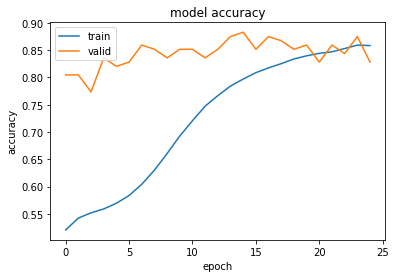

22

In [39]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
22

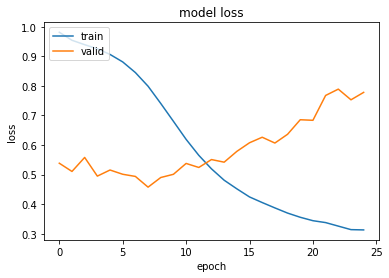

In [40]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()